## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


### Exploration

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# import gymnasium as gym
# from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data_file_path = '../data/synthetic-acute-hypotension-and-sepsis-datasets-based-on-mimic-iii-and-published-as-part-of-the-health-gym-project-1.0.0/C001_FakeHypotension.csv'

In [3]:
df = pd.read_csv(data_file_path)
print(f'Number of unique patients: {df["PatientID"].nunique()}')
df.head()

Number of unique patients: 3910


,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total,urine_m,ALT_AST_m,FiO2_m,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,PatientID,Timepoints
0,0,67.964940,56.709198,144.578430,241.00052,24.226444,23.811718,83.46306,1.477299,0.893153,...,15,0,0,0,1,0,0,0,0,0
1,1,63.603493,53.635162,143.283780,230.52171,23.933348,30.188170,120.01681,1.733099,0.862924,...,15,0,0,0,0,0,0,0,0,1
2,2,65.750670,56.904236,143.534000,217.76741,21.803823,26.318861,84.16420,1.375228,0.819521,...,15,0,0,0,0,0,0,0,0,2
3,3,44.684580,41.952940,117.236534,291.90466,33.613720,24.136852,102.35325,1.252799,0.754315,...,15,1,0,0,0,0,0,0,0,3
4,4,61.486233,63.960106,111.537060,435.26230,45.407272,23.192320,63.73771,1.845126,1.155209,...,15,0,0,0,1,0,0,0,0,4


---

### Following HealthGym Tutorial

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_decomposition import PLSCanonical
from sklearn.cluster import KMeans

In [5]:
# divide state and action pairs
df = pd.read_csv(data_file_path)
print(f'Number of unique patients: {df["PatientID"].nunique()}')

num_patients = df['PatientID'].nunique()

actions = ['fluid_boluses', 'vasopressors']
df_state = df.drop(columns=actions)
df_action = df[actions]

Number of unique patients: 3910


In [6]:
# cross decomposition to reduce the dimensionality of the state space to 5 variables
df_action = pd.get_dummies(df_action, prefix=['fluid_boluses'], columns=['fluid_boluses'])
df_action = pd.get_dummies(df_action, prefix=['vasopressors'], columns=['vasopressors'])

# partial least squares regression
plsca = PLSCanonical(n_components=5)
X = df_state.astype(float).values
Y = df_action.astype(float).values
X_norm = (X-X.mean(axis=0))/(X.std(axis=0))
Y_norm = (Y-Y.mean(axis=0))/(Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [7]:
# k-means clustering to assign each patient to one of the 100 clusters
# An appropriate number of clusters can be determined e.g. by looking at improvements in the Davies Boulding score.
num_states = 100
km = KMeans(n_clusters = num_states, n_init = 10, random_state = 123, verbose = True)
state_number = km.fit(X_canonical).labels_

Initialization complete
Iteration 0, inertia 263047.1816022765.
Iteration 1, inertia 244652.36517827594.
Iteration 2, inertia 239230.44776363368.
Iteration 3, inertia 236391.33677104334.
Iteration 4, inertia 234571.78878517714.
Iteration 5, inertia 233267.22236344984.
Iteration 6, inertia 232262.36108907458.
Iteration 7, inertia 231510.32518505765.
Iteration 8, inertia 230893.20823418026.
Iteration 9, inertia 230360.94227912225.
Iteration 10, inertia 229882.167458714.
Iteration 11, inertia 229448.8877800943.
Iteration 12, inertia 229070.12246020295.
Iteration 13, inertia 228741.20487226115.
Iteration 14, inertia 228459.73134332927.
Iteration 15, inertia 228208.59944884278.
Iteration 16, inertia 228003.12561648083.
Iteration 17, inertia 227817.86696566417.
Iteration 18, inertia 227660.76869085012.
Iteration 19, inertia 227519.99931017635.
Iteration 20, inertia 227383.14596302534.
Iteration 21, inertia 227250.4899185698.
Iteration 22, inertia 227123.2046205402.
Iteration 23, inertia 2270

Before implementing the actual reinforcement learning algorithm, let’s add a few useful variables to the dataframe. ‘hour’ represents the hour (between 0 and 47) in which measurements were taken, ‘action_number’ is a number between 0 and 15 indicating the action taken (every combination of four levels of administered fluid boluses and four levels of vasopressors), ‘state_number’ indicates the cluster associated with the state at time t, and ‘state_number_tp1’ indicates the cluster associated with the state at time t+1.

In [8]:
fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}

df['hour'] = np.tile(range(48), num_patients)
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']
df['state_number'] = state_number
df['state_number_tp1'] = df['state_number'].shift(-1)

In [9]:
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [10]:
# 75% of rewards are 0, the agent might struggle to learn
df['reward'].describe()

count    187679.000000
mean         -0.057584
std           0.174738
min          -2.167784
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: reward, dtype: float64

In [11]:
# ignore last hour since we don't observe the reward of action
df = df[df['hour'] < 47]
df['state_number_tp1'] = df['state_number_tp1'].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). [5] It determines an optimal policy in a way similar to standard Q-learning [6], except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [12]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions
# Set to 0 if state-action combination has actually been observed in the data
for index, row in df.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

num_iterations = 100
step_size = 0.1
discount_factor = 0.99  # Changed discount factor to 0.99
diff_tracker = np.zeros((num_iterations, 1))
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in df.iterrows():
        # Discount factor gamma = 0.99
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + discount_factor * np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))
    print([Q_iter, diff_tracker[Q_iter]])

[0, array([0.04381155])]
[1, array([0.00871222])]
[2, array([0.00511356])]
[3, array([0.00354464])]
[4, array([0.00264782])]
[5, array([0.00206952])]
[6, array([0.0016683])]
[7, array([0.00137531])]
[8, array([0.00115284])]
[9, array([0.00097869])]
[10, array([0.00083904])]
[11, array([0.00072488])]
[12, array([0.00063011])]
[13, array([0.00055046])]
[14, array([0.00048284])]
[15, array([0.00042495])]
[16, array([0.00037506])]
[17, array([0.00033182])]
[18, array([0.00029416])]
[19, array([0.00026123])]
[20, array([0.00023234])]
[21, array([0.00020692])]
[22, array([0.00018449])]
[23, array([0.00016467])]
[24, array([0.0001471])]
[25, array([0.00013151])]
[26, array([0.00011766])]
[27, array([0.00010533])]
[28, array([9.43437885e-05])]
[29, array([8.45464881e-05])]
[30, array([7.58000448e-05])]
[31, array([6.79852335e-05])]
[32, array([6.09976206e-05])]
[33, array([5.47454855e-05])]
[34, array([4.91480805e-05])]
[35, array([4.41341647e-05])]
[36, array([3.96407628e-05])]
[37, array([3.

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

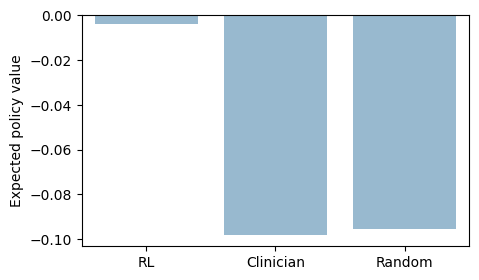

In [13]:
# evaluate
Q_RL = 0
Q_clinician = 0
Q_random =0 

for index, row in df.iterrows():
    if row['hour'] == 0:
        Q_RL += np.nanmax(Q[int(row['state_number']), :])
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]
Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.barplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.5)
plt.ylabel('Expected policy value')
plt.show()

/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_71525/469497237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_71525/469497237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_71525/469497237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

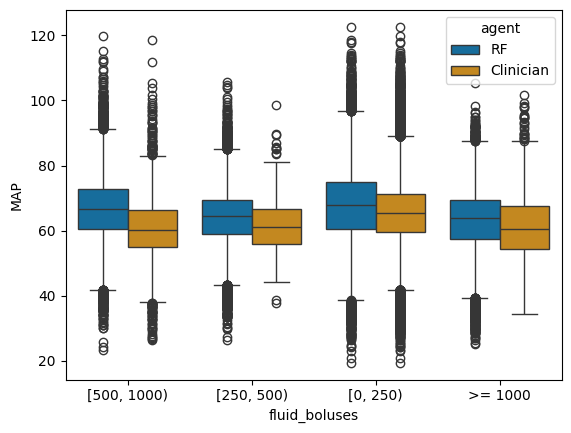

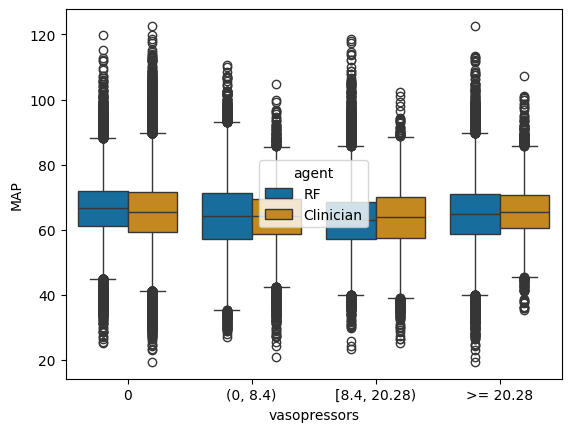

In [14]:
df_boxplot_RF = df[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in df.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}
df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.show()
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.show()

---

### Replacing the Q-Table with a Dueling DDQN

In [31]:
from tqdm import tqdm
import torch
import random
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc_value = nn.Linear(128, 64)
        self.fc_adv = nn.Linear(128, 64)
        
        self.value = nn.Linear(64, 1)
        self.advantage = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        value = torch.relu(self.fc_value(x))
        advantage = torch.relu(self.fc_adv(x))
        
        value = self.value(value)
        advantage = self.advantage(advantage)
        
        # Combine value and advantage streams
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return torch.tanh(q_values)  # Bound Q-values

class BatchConstrainedReplayBuffer:
    def __init__(self, capacity, num_actions):
        self.buffer = deque(maxlen=capacity)
        self.action_freq = np.zeros((num_actions,))
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        self.action_freq[action] += 1
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (torch.FloatTensor(states),
                torch.LongTensor(actions),
                torch.FloatTensor(rewards),
                torch.FloatTensor(next_states),
                torch.FloatTensor(dones))
    
    def get_action_mask(self):
        # Create a mask to filter out actions that are under-represented
        action_probs = self.action_freq / np.sum(self.action_freq)
        return torch.FloatTensor(action_probs) > 0.01  # Filter low-frequency actions
    
    def __len__(self):
        return len(self.buffer)
    

def train_dueling_ddqn(dueling_dqn, target_dqn, buffer, optimizer, batch_size=64, gamma=0.99, tau=0.005):
    if len(buffer.buffer) < batch_size:
        return None
    
    # Sample from buffer
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
    
    # Compute Q-values using the online network
    q_values = dueling_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute target Q-values with constrained action selection
    with torch.no_grad():
        next_q_values = target_dqn(next_states)
        
        # Mask actions based on observed offline data (Batch-Constrained Q-learning)
        action_mask = buffer.get_action_mask()
        masked_next_q_values = next_q_values * action_mask
        
        # Select the max Q-value only from valid actions
        next_actions = masked_next_q_values.argmax(1)
        next_q_value_max = masked_next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        # Compute the target Q-values using Double DQN update
        target_q_values = rewards + (gamma * next_q_value_max * (1 - dones))

    # Compute loss (mean squared error)
    loss = nn.MSELoss()(q_values, target_q_values)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update target network
    for target_param, param in zip(target_dqn.parameters(), dueling_dqn.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
    
    return loss.item()


def train_conservative_dueling_ddqn(dueling_dqn, target_dqn, buffer, optimizer, batch_size=64, gamma=0.99, tau=0.001, alpha=0.001):
    if len(buffer.buffer) < batch_size:
        return None
    
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
    
    q_values = dueling_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = dueling_dqn(next_states)
        action_mask = buffer.get_action_mask()
        masked_next_q_values = next_q_values * action_mask
        next_actions = masked_next_q_values.argmax(1)
        
        next_q_value_max = target_dqn(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        target_q_values = rewards + (gamma * next_q_value_max * (1 - dones))

    q_values_all = dueling_dqn(states)
    conservative_loss = (q_values_all.mean(dim=1) - q_values).mean()
    
    loss = F.mse_loss(q_values, target_q_values) + alpha * conservative_loss

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(dueling_dqn.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()

    for target_param, param in zip(target_dqn.parameters(), dueling_dqn.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
    
    return loss.item()

Iteration: 1, Loss: 0.05855607986450195
Iteration: 1001, Avg Loss: 4.422023147344589e-05
Iteration: 2001, Avg Loss: 5.385705456137657e-05
Iteration: 3001, Avg Loss: 2.9110534116625786e-05
Iteration: 4001, Avg Loss: 7.373417913913726e-05
Iteration: 5001, Avg Loss: 6.318230181932449e-05
Iteration: 6001, Avg Loss: 4.094837233424187e-05
Iteration: 7001, Avg Loss: 2.1156923845410347e-05
Iteration: 8001, Avg Loss: 4.410691186785698e-05
Iteration: 9001, Avg Loss: 3.348800539970398e-05
Iteration: 10001, Avg Loss: 3.847193717956543e-05
Iteration: 11001, Avg Loss: 2.3449720814824104e-05
Iteration: 12001, Avg Loss: 2.4425847455859184e-05
Iteration: 13001, Avg Loss: 2.7254760265350343e-05
Iteration: 14001, Avg Loss: 5.299507826566696e-05
Iteration: 15001, Avg Loss: 4.2805634438991544e-05
Iteration: 16001, Avg Loss: 2.6702335104346276e-05
Iteration: 17001, Avg Loss: 9.985879808664322e-05
Iteration: 18001, Avg Loss: 5.77550707384944e-06
Iteration: 19001, Avg Loss: 4.470055550336838e-05
Iteration: 20

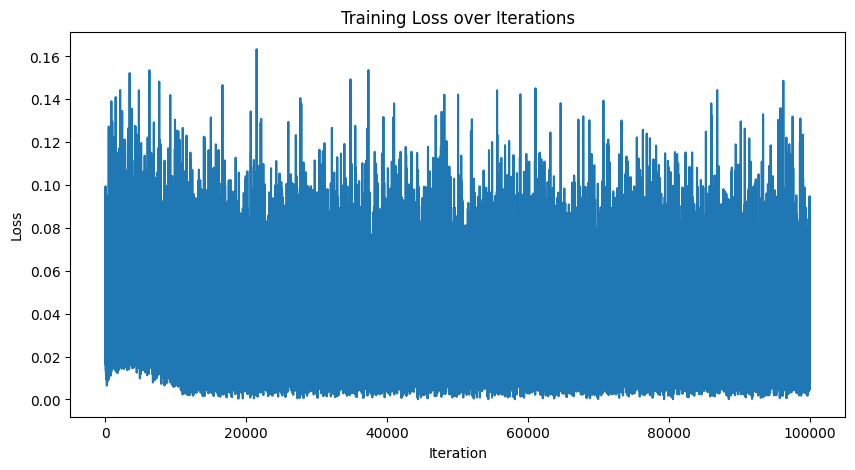

In [32]:
state_dim = 5  # Adjust as needed based on your dimensionality reduction step
action_dim = 16  # There are 16 actions (combinations of fluid boluses and vasopressors)

dueling_dqn = DuelingDQN(state_dim, action_dim)
target_dqn = DuelingDQN(state_dim, action_dim)
optimizer = optim.Adam(dueling_dqn.parameters(), lr=0.0001)

buffer = BatchConstrainedReplayBuffer(capacity=50000, num_actions=action_dim)

# Training loop
num_iterations = 100000
batch_size = 64
gamma = 0.99
tau = 0.005

for index, row in df.iterrows():
     # ignore last hour since we don't observe the reward of next state
    if row['Timepoints'] == 48:
        continue

    state = np.array(X_canonical[index])
    action = int(row['action_number'])
    reward = row['reward']
    next_state = np.array(X_canonical[index+1])
    done = 0 # since we ignore the last hour
    # add transition to buffer
    buffer.add(state, action, reward, next_state, done)


# Store loss values
loss_values = []


for iteration in range(num_iterations):
    total_loss = 0
    loss = train_conservative_dueling_ddqn(dueling_dqn, target_dqn, buffer, optimizer, batch_size, gamma, tau)
    total_loss += loss
    loss_values.append(loss)  # Append the loss value to the list


    if iteration == 0:
        print(f'Iteration: {iteration+1}, Loss: {total_loss}')

    if (iteration>0) and (iteration) % 1000 == 0:
        avg_loss = total_loss / 1000
        print(f'Iteration: {iteration+1}, Avg Loss: {avg_loss}')
        total_loss = 0.0

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Q_RL = 0
Q_clinician = 0
Q_random = 0

# Set model to evaluation mode
dueling_dqn.eval()

# Evaluate the performance of the RL, clinician, and random policies
for index, row in df.iterrows():
    state = torch.FloatTensor(X_canonical[index]).unsqueeze(0) # Get the current state

    # Use Dueling DQN to get Q-values for all actions in the current state
    with torch.no_grad():
        q_values = dueling_dqn(state).cpu().numpy().flatten()

    # Dueling DQN-based policy (RL agent)
    Q_RL += np.max(q_values)

    # Clinician's policy (use the clinician's chosen action)
    clinician_action = int(row['action_number'])
    Q_clinician += q_values[clinician_action]

    # Random policy (select a random valid action)
    valid_q_values = q_values[~np.isnan(q_values)]
    Q_random += np.random.choice(valid_q_values)

# Normalize by the number of patients
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients


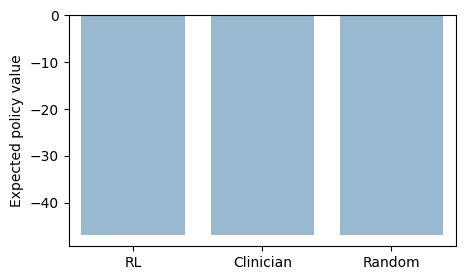

In [34]:
# Visualization
plt.figure(figsize=(5, 3))
sns.barplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.5)
plt.ylabel('Expected policy value')
plt.show()

/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_72697/1707069770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_72697/1707069770.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_72697/1707069770.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

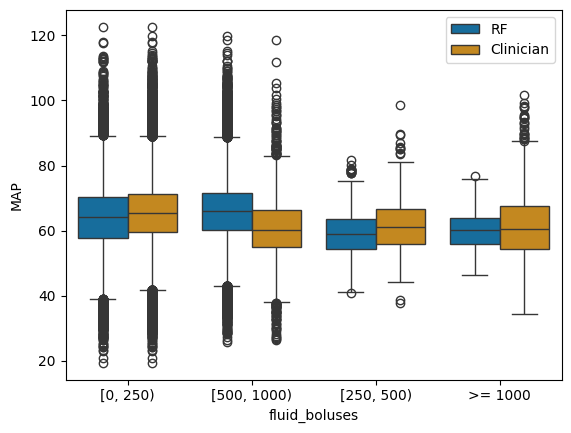

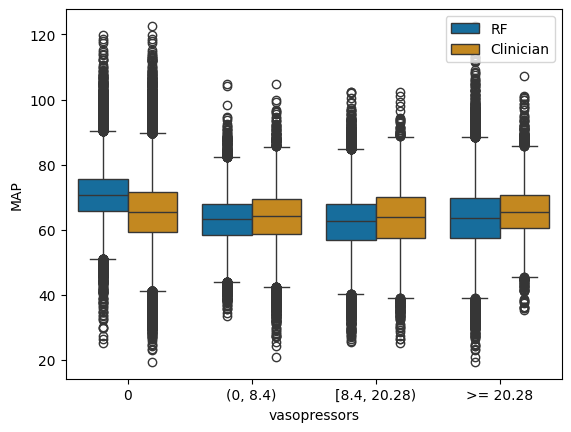

In [24]:
df_boxplot_RF = df[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in df.iterrows():
    state = torch.FloatTensor(X_canonical[index]).unsqueeze(0)  # Get the current state and reshape

    # Use Dueling DQN to get Q-values for the current state
    with torch.no_grad():  # Disable gradient calculation
        q_values = dueling_dqn(state).cpu().numpy().flatten()

    # Get the action with the maximum Q-value
    df_boxplot_RF.at[index, 'action_number'] = np.argmax(q_values)

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}
df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.show()
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.show()

---

# Replacing the Q-Table with a Distributional DQN

In [25]:
from tqdm import tqdm
import torch
import random
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F

class DistributionalDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_atoms=51, v_min=-10, v_max=10):
        super(DistributionalDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max

        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim * num_atoms)
        )

        self.register_buffer("supports", torch.arange(v_min, v_max + (v_max - v_min) / (num_atoms - 1), (v_max - v_min) / (num_atoms - 1)))

    def forward(self, state):
        batch_size = state.size(0)
        dist = self.network(state).view(batch_size, self.action_dim, self.num_atoms)
        return F.softmax(dist, dim=-1)

    def get_q_values(self, state):
        dist = self.forward(state)
        q_values = (dist * self.supports).sum(-1)
        return q_values

def train_distributional_dqn(dist_dqn, target_dqn, buffer, optimizer, batch_size=64, gamma=0.99, tau=0.01):
    if len(buffer.buffer) < batch_size:
        return None
    
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
    
    # Compute distributional Q-values
    dist = dist_dqn(states)
    current_dist = dist[range(batch_size), actions]

    with torch.no_grad():
        next_dist = target_dqn(next_states)
        next_actions = dist_dqn.get_q_values(next_states).argmax(1)
        next_dist = next_dist[range(batch_size), next_actions]

        # Compute projected distribution
        tz = rewards.unsqueeze(-1) + gamma * (1 - dones).unsqueeze(-1) * target_dqn.supports
        tz = tz.clamp(min=dist_dqn.v_min, max=dist_dqn.v_max)
        b = (tz - dist_dqn.v_min) / ((dist_dqn.v_max - dist_dqn.v_min) / (dist_dqn.num_atoms - 1))
        l = b.floor().long()
        u = b.ceil().long()

        # Distribute probability
        projected_dist = torch.zeros_like(current_dist)
        projected_dist.scatter_add_(-1, l, next_dist * (u.float() - b))
        projected_dist.scatter_add_(-1, u, next_dist * (b - l.float()))

    # Compute cross-entropy loss
    loss = -(projected_dist * current_dist.log()).sum(-1).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update target network
    for target_param, param in zip(target_dqn.parameters(), dist_dqn.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
    
    return loss.item()


In [ ]:
df['reward'].describe()

In [ ]:
# v_min and v_max define the range of possible cumulative rewards.
# They determine the support for the Q-value distribution in Distributional DQN.
# Set these based on expected min/max returns to capture the range of outcomes.

# choosing vmin and vmax, use theoretical bounds if time goes to infinity
gamma = 0.99
v_min = df['reward'].min() / (1-gamma)
v_max = df['reward'].max() / (1-gamma) + 10

v_min, v_max

In [ ]:
state_dim = 5  
action_dim = 16  

# Initialize Distributional DQN
# v_min, v_max = -10, 10 # 
num_atoms = 51  # Number of atoms for the distribution

dist_dqn = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
target_dqn = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
optimizer = optim.Adam(dist_dqn.parameters(), lr=0.0001)

buffer = BatchConstrainedReplayBuffer(capacity=50000, num_actions=action_dim)

# Training loop
num_iterations = 100000
batch_size = 64
gamma = 0.99
tau = 0.005

for index, row in df.iterrows():
    # ignore last hour since we don't observe the reward of next state
    if row['Timepoints'] == 48:
        continue

    state = np.array(X_canonical[index])
    action = int(row['action_number'])
    reward = row['reward']
    next_state = np.array(X_canonical[index+1])
    done = 0  # since we ignore the last hour
    # add transition to buffer
    buffer.add(state, action, reward, next_state, done)


# Store loss values
loss_values = []

for iteration in range(num_iterations):
    total_loss = 0
    loss = train_distributional_dqn(dist_dqn, target_dqn, buffer, optimizer, batch_size, gamma, tau)
    
    if loss is not None:
        total_loss += loss
        loss_values.append(loss)  # Append the loss value to the list

    if iteration == 0:
        print(f'Iteration: {iteration+1}, Loss: {total_loss}')

    if (iteration > 0) and (iteration + 1) % 1000 == 0:
        avg_loss = total_loss / 1000
        print(f'Iteration: {iteration+1}, Avg Loss: {avg_loss}')
        total_loss = 0.0

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

Q_RL = 0
Q_clinician = 0
Q_random = 0

# Set model to evaluation mode
dist_dqn.eval()

# Evaluate the performance of the RL, clinician, and random policies
for index, row in df.iterrows():
    state = torch.FloatTensor(X_canonical[index]).unsqueeze(0)  # Get the current state

    # Use Distributional DQN to get Q-values for all actions in the current state
    with torch.no_grad():
        q_values = dist_dqn.get_q_values(state).cpu().numpy().flatten()

    # Distributional DQN-based policy (RL agent)
    Q_RL += np.max(q_values)

    # Clinician's policy (use the clinician's chosen action)
    clinician_action = int(row['action_number'])
    Q_clinician += q_values[clinician_action]

    # Random policy (select a random valid action)
    valid_q_values = q_values[~np.isnan(q_values)]
    Q_random += np.random.choice(valid_q_values)

# Normalize by the number of patients
num_patients = len(df)
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.barplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.5)
plt.ylabel('Expected policy value')
plt.show()

In [ ]:
df_boxplot_RL = df[['MAP']].copy()
df_boxplot_RL['action_number'] = 0

# Set the model to evaluation mode
dist_dqn.eval()

for index, row in df.iterrows():
    state = torch.FloatTensor(X_canonical[index]).unsqueeze(0)  # Get the current state and reshape

    # Use Distributional DQN to get Q-values for the current state
    with torch.no_grad():  # Disable gradient calculation
        q_values = dist_dqn.get_q_values(state).cpu().numpy().flatten()

    # Get the action with the maximum Q-value
    df_boxplot_RL.at[index, 'action_number'] = np.argmax(q_values)

df_boxplot_RL['agent'] = 'RL'
df_boxplot_clinician = df[['MAP', 'action_number']].copy()
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RL, df_boxplot_clinician], ignore_index=True, sort=False)

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}
df_boxplot['fluid_boluses'] = df_boxplot['action_number'].map(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].map(vasopressors_dict)

plt.figure(figsize=(12, 6))
sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP vs Fluid Boluses")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP vs Vasopressors")
plt.tight_layout()
plt.show()

---

### Using Conservative Q-Learning from `d3rlpy`

Prepare the dataset:

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL, CQLConfig, DiscreteCQLConfig, DiscreteCQL

In [ ]:
# load data
df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')

num_patients = df['PatientID'].nunique()

In [4]:
# transform action & assign reward
fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}

df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [11]:
# scale data
state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2', 'lactic_acid', 'serum_creatinine',
                 'FiO2', 'GCS_total', 'urine_m', 'ALT_AST_m', 'FiO2_m', 'GCS_total_m', 'PO2_m', 'lactic_acid_m', 'serum_creatinine_m']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[state_columns]), columns=state_columns)
df_scaled["id"] = df["PatientID"]
df_scaled["hour"] = df["Timepoints"]
df_scaled["action"] = df["action_number"]
df_scaled["reward"] = df["reward"]

In [12]:
# convert into numpy arrays
states = []
actions = []
rewards = []
next_states = []
dones = [] 

for idx, row in df_scaled.iterrows():
    if row["hour"] == 47: # terminal state
        done = 1
        next_state = row[state_columns].values # use current state
        reward = 0
    else:
        done = 0
        patient_id = row["id"]
        next_state = df_scaled[(df_scaled["id"]==patient_id) & (df_scaled["hour"]==row["hour"]+1)][state_columns].values[0]
        reward = row["reward"]

    state = row[state_columns].values
    action = row["action"]
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    dones.append(done)

states = np.array(states)
actions = np.array(actions)
rewards = np.array(rewards)
next_states = np.array(next_states)
dones = np.array(dones)

In [18]:
# create a dataset for d3rlpy
dataset = {
    "observations": states,
    "actions": actions,
    "rewards": rewards,
    "next_observations": next_states,
    "terminals": dones
}

In [ ]:
# create MDP dataset
mdp_dataset = MDPDataset(
    observations=dataset['observations'],
    actions=dataset['actions'],
    rewards=dataset['rewards'],
    terminals=dataset['terminals'],
    #next_observations=dataset['next_observations']
)

In [35]:
# initialize CQL algorithm
cql = DiscreteCQLConfig().create(device="mps")
# Train with TensorBoard logging
cql.build_with_dataset(mdp_dataset)

In [ ]:
# setup metrics
from d3rlpy.metrics import TDErrorEvaluator, AverageValueEstimationEvaluator, DiscreteActionMatchEvaluator

test_episodes = mdp_dataset.episodes[:30]
cql.fit(
    mdp_dataset, 
    n_steps=100000,
    evaluators={
        "td_error": TDErrorEvaluator(test_episodes),
        "value_scale": AverageValueEstimationEvaluator(test_episodes),
        "action_match": DiscreteActionMatchEvaluator(test_episodes)
    }
)

Off-policy evaluation

In [37]:
# save model
cql.save('cql.d3')
cql.save_policy('cql_policy.pt')

In [ ]:
import d3rlpy

# off-policy evaluation
fqe = d3rlpy.ope.DiscreteFQE(algo=cql, config=d3rlpy.ope.FQEConfig(), device="mps")
# train estimators to evaluate the trained policy
fqe.fit(
    mdp_dataset,
    n_steps=100000,
    evaluators={
        "init_value": d3rlpy.metrics.InitialStateValueEstimationEvaluator(),
        "soft_opc": d3rlpy.metrics.SoftOPCEvaluator(return_threshold=-300)
    }
)

In [ ]:
df_scaled